# Logistic Regression

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [103]:
random_seed = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = ["Default"]

In [104]:
df = pd.read_csv("sba_clean.csv")
df

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default
0,15,38,1,16,30,2,84,4,0,1,0,0,0,1,60000,60000,48000,80,0
1,15,18,0,0,30,2,60,2,0,1,0,0,0,1,40000,40000,32000,80,0
2,15,18,0,7,30,2,180,7,0,0,0,0,0,0,287000,287000,215250,75,0
3,36,39,0,20,30,2,60,2,0,0,0,0,0,1,35000,35000,28000,80,0
4,9,11,0,20,30,2,240,14,1,0,0,0,0,0,229000,229000,229000,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894605,35,17,1,16,30,2,60,6,0,0,0,0,0,0,70000,70000,56000,80,0
894606,35,17,1,16,30,2,60,6,0,0,0,0,1,0,85000,85000,42500,50,0
894607,4,5,0,10,30,2,108,26,0,0,0,0,0,0,300000,300000,225000,75,0
894608,11,14,0,20,30,2,60,6,0,0,0,0,0,1,75000,75000,60000,80,1


## Min-Max Scaling

Algoritmos sensibles a la escala, como k-Nearest Neighbors (k-NN) y redes neuronales con funciones de activación basadas en distancias (como la función sigmoide), pueden beneficiarse de la normalización.

In [ ]:
# scaler = MinMaxScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# df.sample(3)

## Z-Score Scaling

Algunos algoritmos, como la Regresión Logística y el Support Vector Machine (SVM), funcionan mejor con datos estandarizados, ya que asumen una distribución normal.

In [105]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default
803256,10,12,0,20,28,9,-0.188892,-0.073505,0,0,0,0,0,1,-0.423624,-0.399963,-0.341389,1.094763,0
57731,4,5,0,20,30,7,2.394339,0.115958,1,0,0,0,0,0,-0.434090,-0.410540,-0.403696,0.231127,0
706708,48,49,1,13,37,4,-0.340847,-0.127637,0,0,1,0,0,0,-0.527794,-0.505738,-0.546893,-1.208265,0


## Split Train-Test

In [106]:
X = df.drop(columns=target)
y = df[target[0]]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed)

In [108]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (626227, 18), (626227,)
Test:  (268383, 18), (268383,)


## Training Model

In [109]:
log_reg = LogisticRegression()

In [110]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2", "elasticnet"],
              "random_state": [random_seed]}

In [111]:
grid_lr = GridSearchCV(log_reg, param_grid, cv=10)
grid_lr.fit(X_train, y_train)

In [128]:
params = grid_lr.best_params_

print("Better Parameters:", params)

Better Parameters: {'C': 0.1, 'penalty': 'l2', 'random_state': 44}


In [132]:
lr_model = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=44)

In [182]:
acc_lr = lr_model.score(X_test, y_test)

print("Accuracy:", round(acc_lr, 4))

Accuracy: 0.8542


## Cross-Validation

In [137]:
results = cross_val_score(lr_model, X_train, y_train, cv=10)

print("Results:", results)
print("Accuracy (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.85452629 0.85516504 0.85588362 0.85514907 0.85467001 0.85444645
 0.85676189 0.85292709 0.85586535 0.85495513]
Accuracy (mean +/- desv): 0.8550 +/- 0.0010


In [141]:
y_cv = cross_val_predict(lr_model, X, y, cv=10)
acc_cv = accuracy_score(y, y_cv)

print("Accuracy:", round(acc_cv, 4))

Accuracy: 0.8517


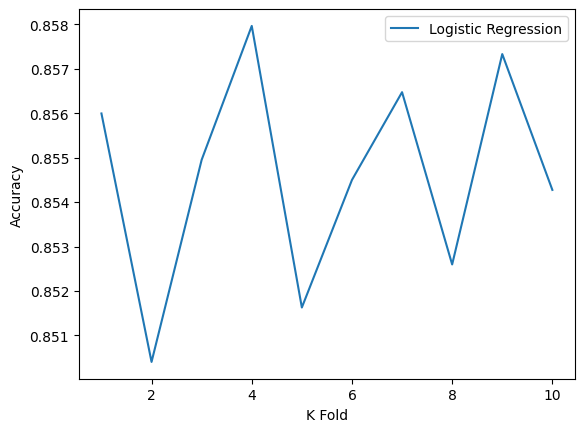

In [174]:
kf = KFold(n_splits=10, shuffle=True)

scores = cross_val_score(lr_model, X_test, y_test, cv=kf, scoring="accuracy")
plt.plot(range(1, 11), scores, label="Logistic Regression")
plt.xlabel("K Fold")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

## Metrics

In [134]:
y_pred = lr_model.predict(X_test)

In [181]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8542
Precisión:    0.7850
Sensibilidad: 0.6389
F1-score:     0.6713


In [146]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8667    0.9722    0.9165    220842
           1     0.7033    0.3056    0.4261     47541

    accuracy                         0.8542    268383
   macro avg     0.7850    0.6389    0.6713    268383
weighted avg     0.8378    0.8542    0.8296    268383



In [192]:
cm_lr = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_lr)

[[0.80001714 0.02284422]
 [0.12299959 0.05413905]]


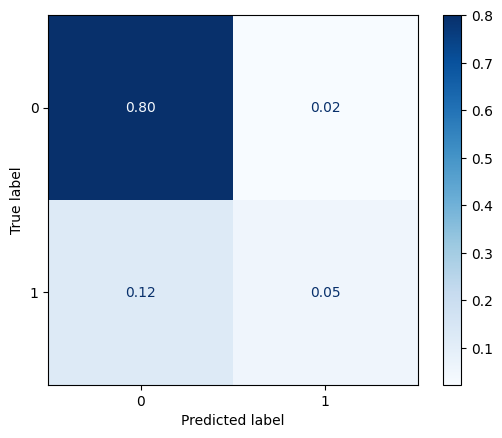

In [193]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lr_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

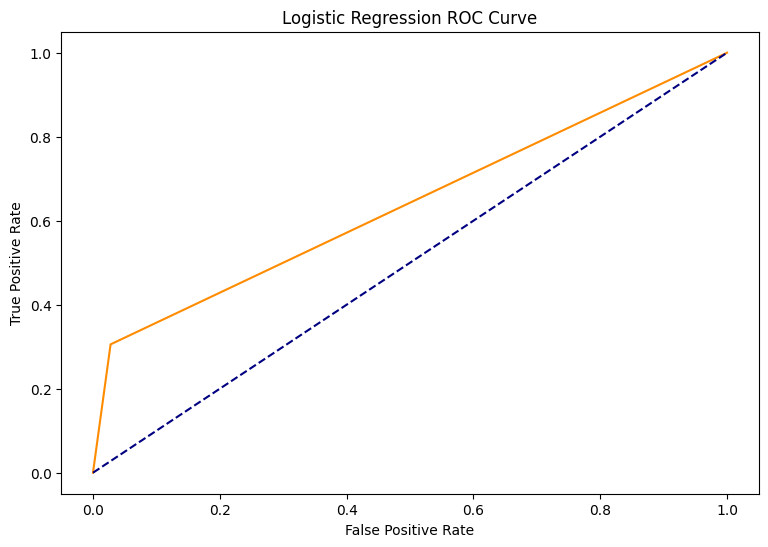

In [204]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

## Interpretability